# Federated PCA for Face Images Decomposition

Principal component analysis (PCA) is a dimesion reduction technique. It learns an **orthogonal linear transformation**, which transforms the original data into a new coordinate system, such that most of the variation can be explained by a few dimensions (known as the principal component directions). PCA helps uncover patterns in the data by representing it in a lower-dimension latent space, thus making it an important technique for exploratory analysis and data visualization. It is also very helpful in reducing the number of features for subsequent predictive models, enabling more efficient and robust modelling of high-dimensional data.

In this example, we apply the federated version of PCA to decompose face images into a set of basis images, called the "eigenfaces", which can then be used to build face recognition models in downstream tasks. We consider the [Olivetti dataset](https://cam-orl.co.uk/facedatabase.html) consisting of 400 face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge. The original images are of size 64x64 and on greyscale with 256 levels. The pixels have been centered similar to this [example](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#dataset-preparation). Ten percent (40) of the images are reserved for evaluation, while the rest are equally split into 2 sets (180 per set) representing local silos under a horizontal federated learning setting. Next we will show step-by-step how to perform federated PCA with the Integrate.ai SDK.


## Setup
1. Download the data from this [link](https://s3.ca-central-1.amazonaws.com/public.s3.integrate.ai/fl-demo/olivetti_faces.zip) and unzip it. There are 3 files under the directory `olivetti_faces` corresponding to the two siloed data and the evaulation data.
2. Use the `integrate-ai` CLI tool to install the latest SDK and pull the server/client docker images. Some useful commands:
    ```bash
    pip install integrate-ai
    iai --help
    iai sdk install
    iai client pull
    iai server pull
    ```

In [ ]:
# Authorize and initialize the SDK client
import os
from integrate_ai_sdk.api import connect


IAI_TOKEN = os.environ.get("IAI_TOKEN")
client = connect(token=IAI_TOKEN)

In [3]:
# Specify data directory where the olivetti_faces data is saved
# Change this to a local directory on your machine
DATA_DIR = "<local-data-directory>/olivetti_faces"
train_path1 = f"{DATA_DIR}/client_1.parquet"
train_path2 = f"{DATA_DIR}/client_2.parquet"
test_path = f"{DATA_DIR}/test.parquet"

# Specify path where the model artifacts will be saved
# Change this to a local directory on your machine
storage_path = "/tmp/iai-test-docker-taskbuilder"

## Federated PCA

We begin with a quick look at the evaluation data to understand how it is structured.

In [4]:
from math import ceil
import matplotlib.pyplot as plt


def plot_gallery(title, images, n_col=3, image_shape=(64, 64), cmap=plt.cm.gray):
    n_row = ceil(images.shape[0] / n_col)
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

In [5]:
import pandas as pd


test_faces = pd.read_parquet(test_path).values
print(test_faces.shape)

(40, 4096)


As shown above, there are 40 images in the evaluation set, each flattened as a 4096-dimensional vector (64x64). We can reshape them back into 2D arrays. The following cell shows the first 6 images in the dataset. Since human faces follow some consistent patterns, the pixels of these images are correlated. Intuitively, we do not need the full 4096 dimensions to characterize them. This motivates the application of PCA to find a low-dimension representation of the images.

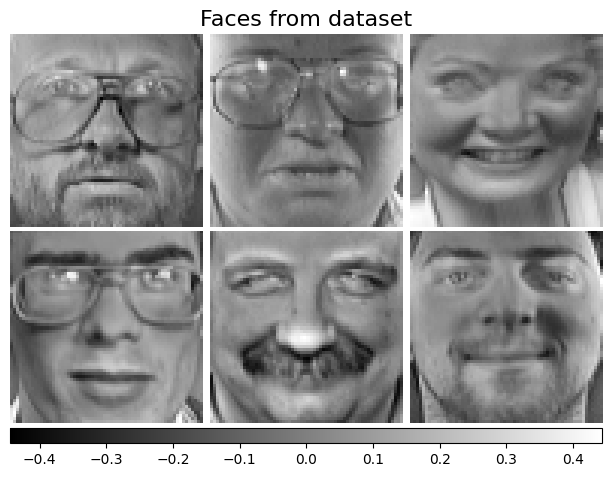

In [6]:
plot_gallery("Faces from dataset", test_faces[:6])

We use the follwoing model and data configuration for our federated PCA session. We consider the first 16 (`n_components`) PC directions to represent the data, reduced from the original 4096 dimensions. `whiten` can be set to `True` if the PCs will be used for downstream face recognition tasks. In data config, we set `predictors` to `[]` such that all 4096 input dimensions are included.

In [7]:
model_config = {
    "strategy": {"name": "FedPCA", "params": {}},
    "model": {
        "params": {
            "n_components": 16,
            "whiten": True
        }
    },
}

data_config = {
    "predictors": []
}

Then we create an FL session with the `iai_pca` package.

In [ ]:
pca_session = client.create_fl_session(
    name="pca_face_image_decomposition",
    description="apply PCA to decompose face images",
    min_num_clients=2,
    num_rounds=2,
    package_name="iai_pca",
    model_config=model_config,
    data_config=data_config,
    startup_mode="external"
).start()

pca_session.id

A task group is created for the session where the FL server and two clients (local silos) are added.

In [9]:
from integrate_ai_sdk.taskgroup.taskbuilder import local
from integrate_ai_sdk.taskgroup.base import SessionTaskGroup


tb = local.local_docker(
    client,
    docker_login=False,
    override_server_image='local/edge-fl-server:latest', 
    override_client_image='local/edge-fl-client:latest-cpu',
)

task_group_context = (
    SessionTaskGroup(pca_session)
    .add_task(tb.fls(storage_path=storage_path, docker_options={"cpu_shares": 512}))\
    .add_task(tb.hfl(train_path=train_path1, test_path=test_path, client_name="client1"))\
    .add_task(tb.hfl(train_path=train_path2, test_path=test_path, client_name="client2"))\
    .start()
)

In [10]:
# wait for the session to complete
task_group_context.wait(60 * 5)

True

Next we can download the learned artifact as a PyTorch model object. The first 16 PC directions are available from the `components` attribute. Similar to the original images, we can reshape the PC directions into 2D arrays and visualize them as images, which are known as the "eigenfaces". The first 3 eigenfaces are shown in the cell below.

We get 16 PC directions of length 4096.


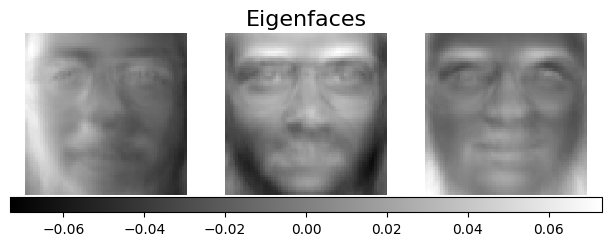

In [19]:
pca_transformation = pca_session.model().as_pytorch()

print(f"We get {pca_transformation.components.shape[0]} PC directions of length {pca_transformation.components.shape[1]}.")

plot_gallery("Eigenfaces", pca_transformation.components[:3])

The proportion of variance explained by each PC is stored in `explained_variance_ratio` attribute.

In [22]:
total_proportion = pca_transformation.explained_variance_ratio.sum().item() * 100
print(f"A total of {total_proportion:.2f}% variance in the original data can be explained by the first 16 principal components.")

A total of 66.89% variance in the original data can be explained by the first 16 principal components.


We can use the model object to transform face images from the original feature space (4096 dimensions) to the new principal component space (16 dimensions). And downstream predictive models for face recognition can be built within this much lower dimension space, which is beyond the scope of this example.

In [24]:
import torch


# transform the images in the evaluation set
test_faces_transformed = pca_transformation(torch.tensor(test_faces))
print(test_faces_transformed.shape)

torch.Size([40, 16])


To verify that the transformed data do preserve most of the information in the original data, we can reconstruct the original images by multiplying the transformed data by the `components` array. This is possible because the PCA projection is orthogonal.

The following cell shows the first 6 reconstructed images in the evaluation set. As we can observe, although a lot of details are lost, the reconstructed images still retain a fairly good amount of information about the raw faces. Note that this is achieved with only 16 dimensions, which is less than `0.5%` of the original data dimension. For this reason, PCA is also sometimes used for data compression.

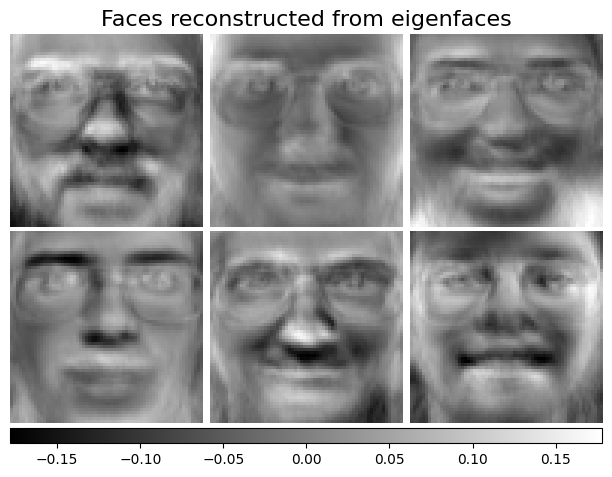

In [26]:
test_faces_recovered = test_faces_transformed @ pca_transformation.components
# visualize the reconstructed faces
plot_gallery("Faces reconstructed from eigenfaces", test_faces_recovered[:6])